In [412]:
import math
import os
import csv
import json
import requests
import random
import matplotlib.pylab as plt

from os import path as osp
from PIL import Image, ImageDraw
from urllib.request import urlretrieve
from k12libs.utils.nb_easy import k12ai_get_top_dir, RACEURL
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from k12libs.utils.nb_easy import k12ai_set_notebook

In [413]:
k12ai_set_notebook(cellw=90)

## show 9 images

In [356]:
images_root = osp.join(k12ai_get_top_dir(), 'assets/dobble/test1')
!ls $images_root

img_0.png  img_2.png  img_4.png  img_6.png  img_8.png
img_1.png  img_3.png  img_5.png  img_7.png


In [391]:
image9_files = os.listdir(images_root)
images9 = [Image.open(osp.join(images_root, fname)) for fname in image9_files]

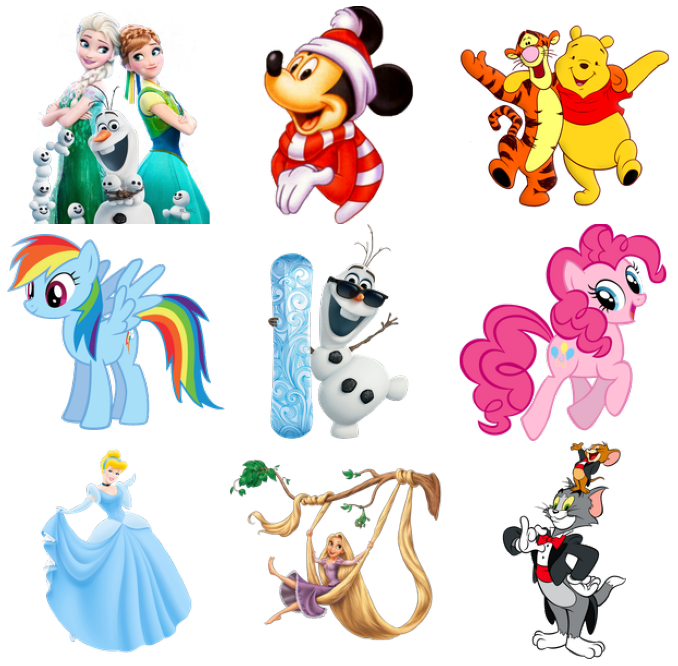

In [360]:
random.shuffle(images9)
nrow, ncol = 3, 3
fig = plt.figure(figsize=(4*nrow, 4*ncol))
for i in range(nrow*ncol):
    ax = fig.add_subplot(nrow, ncol, i+1)
    plt.axis('off')
    plt.imshow(images9[i])
plt.subplots_adjust(wspace =0, hspace =0)

## test polar coordinates system

$$ 
x = \dfrac{-2r + \sqrt{5R^2 - r^2}}{5}
$$

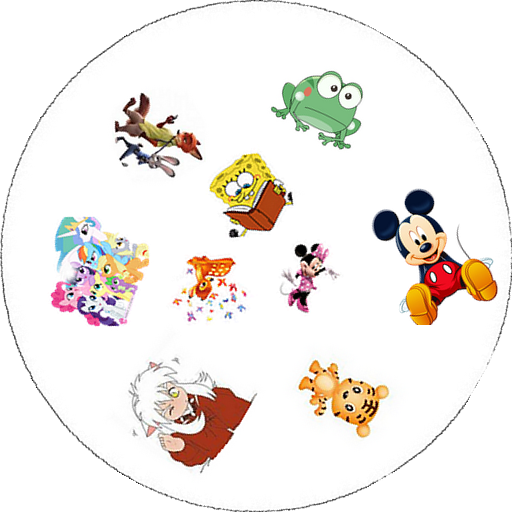

In [409]:
DEBUG = 0

def draw_it(width, ratio, images, outpath):
    flag = True if isinstance(images[0], str) else False
    random.shuffle(images)
    R0 = round(width/2)
    R1 = int(R0*ratio)
    card = Image.new('RGBA', (2*R0, 2*R0))
    draw = ImageDraw.Draw(card)
    
    draw.ellipse((0, 0, card.width-1, card.height-1),
                 fill='#FFFFFF', outline='#000000')
    
    R2 = round(R1 * 0.2)
    
    # 圆环
    if DEBUG:
        draw.ellipse((0, 0, 2*R0, 2*R0), fill=None, outline='#FF0000')
        draw.text((30, 30), f'R0:{R0}', (255, 0, 0), width=4)

        draw.ellipse((R0-R1, R0-R1, R0+R1, R0+R1), fill=None, outline='#00FF00')
        draw.text((R0-R1+30, R0-R1+30), f'R1:{R1}', (0, 255, 0), width=4)

        draw.ellipse((R0-R2, R0-R2, R0+R2, R0+R2), fill=None, outline='#0000FF')
        draw.text((R0-R2+10, R0-R2+10), f'R2:{R2}', (0, 0, 255), width=4)
    
    # 质心/半径
    r1_c = R2 + (R1 - R2) / 2
    r2_c = R1 + (R0 - R1) / 2
    
    if DEBUG:
        draw.ellipse((R0-r1_c, R0-r1_c, R0+r1_c, R0+r1_c), fill=None, outline='#000FF0')
        draw.text((R0-r1_c+10, R0-r1_c+10), f'r1_c:{r1_c}', (0, 0, 255), width=4)

        draw.ellipse((R0-r2_c, R0-r2_c, R0+r2_c, R0+r2_c), fill=None, outline='#00F0F0')
        draw.text((R0-r2_c+50, R0-r2_c+50), f'r2_c:{r2_c}', (0, 0, 255), width=4)
    
    # 矩形框
    # $$ 
    # x = \dfrac{-2r + \sqrt{5R^2 - r^2}}{5}
    # $$
    box_edge1 = 2 * round((-2*R2 + math.sqrt(5*R1*R1 - R2*R2)) / 5)
    box_edge2 = 2 * round((-2*R1 + math.sqrt(5*R0*R0 - R1*R1)) / 5)
    
    # box_icon1 = Image.new('RGBA', (box_edge1, box_edge1), color='gray')
    # box_icon2 = Image.new('RGBA', (box_edge2, box_edge2), color='orange')
    
    box_xy1 = R0 + R2, R0 - round(box_edge1/2) 
    
    imgs = images.copy()
    scale = random.uniform(0.8, 1.0)
    xy = round(scale*box_edge1), round(scale*box_edge1)
    img = imgs.pop()
    if flag:
        img = Image.open(img).convert("RGBA")  
    img = img.resize(xy, Image.ANTIALIAS).rotate(random.randrange(0, 360), resample=Image.BICUBIC)
    card.paste(img, box=box_xy1, mask=img)
    for _ in range(2):
        card = card.rotate(120, resample=Image.BICUBIC) 
        scale = random.uniform(0.8, 1.1)
        xy = round(scale*box_edge1), round(scale*box_edge1)
        img = imgs.pop()
        if flag:
            img = Image.open(img).convert("RGBA")  
        img = img.resize(xy, Image.ANTIALIAS).rotate(random.randrange(0, 360), resample=Image.BICUBIC)
        card.paste(img, box=box_xy1, mask=img)
    
    box_xy2 = R0 + R1, R0 - round(box_edge2/2) 
    card = card.rotate(random.randint(10, 40), resample=Image.BICUBIC) 
    scale = random.uniform(0.6, 1.1)
    xy = round(scale*box_edge2), round(scale*box_edge2)
    img = imgs.pop()
    if flag:
        img = Image.open(img).convert("RGBA")  
    img = img.resize(xy, Image.ANTIALIAS).rotate(random.randrange(0, 360), resample=Image.BICUBIC)
    card.paste(img, box=box_xy2, mask=img)
    for _ in range(5):
        card = card.rotate(60, resample=Image.BICUBIC) 
        scale = random.uniform(0.5, 1.1)
        xy = round(scale*box_edge2), round(scale*box_edge2)
        img = imgs.pop()
        if flag:
            img = Image.open(img).convert("RGBA")  
        img = img.resize(xy, Image.ANTIALIAS).rotate(random.randrange(0, 360), resample=Image.BICUBIC)
        card.paste(img, box=box_xy2, mask=img)
        
    card.save(outpath, dpi=(600, 600), format='PNG', subsampling=0, quality=100)
    
    return card

draw_it(512, 0.42, images9, '/data/1.png')

## Generate 73 cards

In [362]:
cards_seqs = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [0, 9, 10, 11, 12, 13, 14, 15, 16],
    [0, 17, 18, 19, 20, 21, 22, 23, 24],
    [0, 25, 26, 27, 28, 29, 30, 31, 32],
    [0, 33, 34, 35, 36, 37, 38, 39, 40],
    [0, 41, 42, 43, 44, 45, 46, 47, 48],
    [0, 49, 50, 51, 52, 53, 54, 55, 56],
    [0, 57, 58, 59, 60, 61, 62, 63, 64],
    [0, 65, 66, 67, 68, 69, 70, 71, 72],
    [1, 9, 17, 25, 33, 41, 49, 57, 65],
    [1, 10, 18, 26, 34, 42, 50, 58, 66],
    [1, 11, 19, 27, 35, 43, 51, 59, 67],
    [1, 12, 20, 28, 36, 44, 52, 60, 68],
    [1, 13, 21, 29, 37, 45, 53, 61, 69],
    [1, 14, 22, 30, 38, 46, 54, 62, 70],
    [1, 15, 23, 31, 39, 47, 55, 63, 71],
    [1, 16, 24, 32, 40, 48, 56, 64, 72],
    [2, 9, 18, 27, 36, 45, 54, 63, 72],
    [2, 10, 17, 28, 35, 46, 53, 64, 71],
    [2, 11, 20, 25, 34, 47, 56, 61, 70],
    [2, 12, 19, 26, 33, 48, 55, 62, 69],
    [2, 13, 22, 31, 40, 41, 50, 59, 68],
    [2, 14, 21, 32, 39, 42, 49, 60, 67],
    [2, 15, 24, 29, 38, 43, 52, 57, 66],
    [2, 16, 23, 30, 37, 44, 51, 58, 65],
    [3, 9, 19, 29, 39, 46, 56, 58, 68],
    [3, 10, 20, 30, 40, 45, 55, 57, 67],
    [3, 11, 17, 31, 37, 48, 54, 60, 66],
    [3, 12, 18, 32, 38, 47, 53, 59, 65],
    [3, 13, 23, 25, 35, 42, 52, 62, 72],
    [3, 14, 24, 26, 36, 41, 51, 61, 71],
    [3, 15, 21, 27, 33, 44, 50, 64, 70],
    [3, 16, 22, 28, 34, 43, 49, 63, 69],
    [4, 9, 20, 31, 38, 42, 51, 64, 69],
    [4, 10, 19, 32, 37, 41, 52, 63, 70],
    [4, 11, 18, 29, 40, 44, 49, 62, 71],
    [4, 12, 17, 30, 39, 43, 50, 61, 72],
    [4, 13, 24, 27, 34, 46, 55, 60, 65],
    [4, 14, 23, 28, 33, 45, 56, 59, 66],
    [4, 15, 22, 25, 36, 48, 53, 58, 67],
    [4, 16, 21, 26, 35, 47, 54, 57, 68],
    [5, 9, 21, 30, 34, 48, 52, 59, 71],
    [5, 10, 22, 29, 33, 47, 51, 60, 72],
    [5, 11, 23, 32, 36, 46, 50, 57, 69],
    [5, 12, 24, 31, 35, 45, 49, 58, 70],
    [5, 13, 17, 26, 38, 44, 56, 63, 67],
    [5, 14, 18, 25, 37, 43, 55, 64, 68],
    [5, 15, 19, 28, 40, 42, 54, 61, 65],
    [5, 16, 20, 27, 39, 41, 53, 62, 66],
    [6, 9, 22, 32, 35, 44, 55, 61, 66],
    [6, 10, 21, 31, 36, 43, 56, 62, 65],
    [6, 11, 24, 30, 33, 42, 53, 63, 68],
    [6, 12, 23, 29, 34, 41, 54, 64, 67],
    [6, 13, 18, 28, 39, 48, 51, 57, 70],
    [6, 14, 17, 27, 40, 47, 52, 58, 69],
    [6, 15, 20, 26, 37, 46, 49, 59, 72],
    [6, 16, 19, 25, 38, 45, 50, 60, 71],
    [7, 9, 23, 26, 40, 43, 53, 60, 70],
    [7, 10, 24, 25, 39, 44, 54, 59, 69],
    [7, 11, 21, 28, 38, 41, 55, 58, 72],
    [7, 12, 22, 27, 37, 42, 56, 57, 71],
    [7, 13, 19, 30, 36, 47, 49, 64, 66],
    [7, 14, 20, 29, 35, 48, 50, 63, 65],
    [7, 15, 17, 32, 34, 45, 51, 62, 68],
    [7, 16, 18, 31, 33, 46, 52, 61, 67],
    [8, 9, 24, 28, 37, 47, 50, 62, 67],
    [8, 10, 23, 27, 38, 48, 49, 61, 68],
    [8, 11, 22, 26, 39, 45, 52, 64, 65],
    [8, 12, 21, 25, 40, 46, 51, 63, 66],
    [8, 13, 20, 32, 33, 43, 54, 58, 71],
    [8, 14, 19, 31, 34, 44, 53, 57, 72],
    [8, 15, 18, 30, 35, 41, 56, 60, 69],
    [8, 16, 17, 29, 36, 42, 55, 59, 70]
]

In [367]:
images73_root = osp.join(k12ai_get_top_dir(), 'assets/dobble/9_73')
!ls $images73_root

img_0.png   img_20.png	img_32.png  img_44.jpg	 img_56.jpeg  img_68.jpg
img_1.png   img_21.png	img_33.png  img_45.jpeg  img_57.jpeg  img_69.jpg
img_10.png  img_22.png	img_34.png  img_46.jpg	 img_58.jpeg  img_7.png
img_11.png  img_23.png	img_35.png  img_47.jpg	 img_59.jpeg  img_70.jpg
img_12.png  img_24.png	img_36.png  img_48.jpg	 img_6.png    img_71.jpg
img_13.png  img_25.png	img_37.png  img_49.jpg	 img_60.jpg   img_72.jpg
img_14.png  img_26.png	img_38.png  img_5.png	 img_61.jpg   img_73.jpg
img_15.png  img_27.png	img_39.png  img_50.jpg	 img_62.jpg   img_8.png
img_16.png  img_28.png	img_4.png   img_51.jpg	 img_63.jpg   img_9.png
img_17.png  img_29.png	img_40.png  img_52.jpg	 img_64.jpg
img_18.png  img_3.png	img_41.png  img_53.jpeg  img_65.jpg
img_19.png  img_30.png	img_42.jpg  img_54.jpeg  img_66.jpg
img_2.png   img_31.png	img_43.jpg  img_55.jpeg  img_67.jpg


In [411]:
images73_files = os.listdir(images73_root)
images73 = [osp.join(images73_root, fname) for fname in images73_files[:73]]
os.makedirs('/data/dobble', exist_ok=True)
outfiles = []
for i, seq in enumerate(cards_seqs):
    images9 = [images73[j] for j in seq]
    outfiles.append(f'/data/dobble/card_{i}.png')
    draw_it(1024, 0.42, images9, outfiles[-1])

## show 2x2

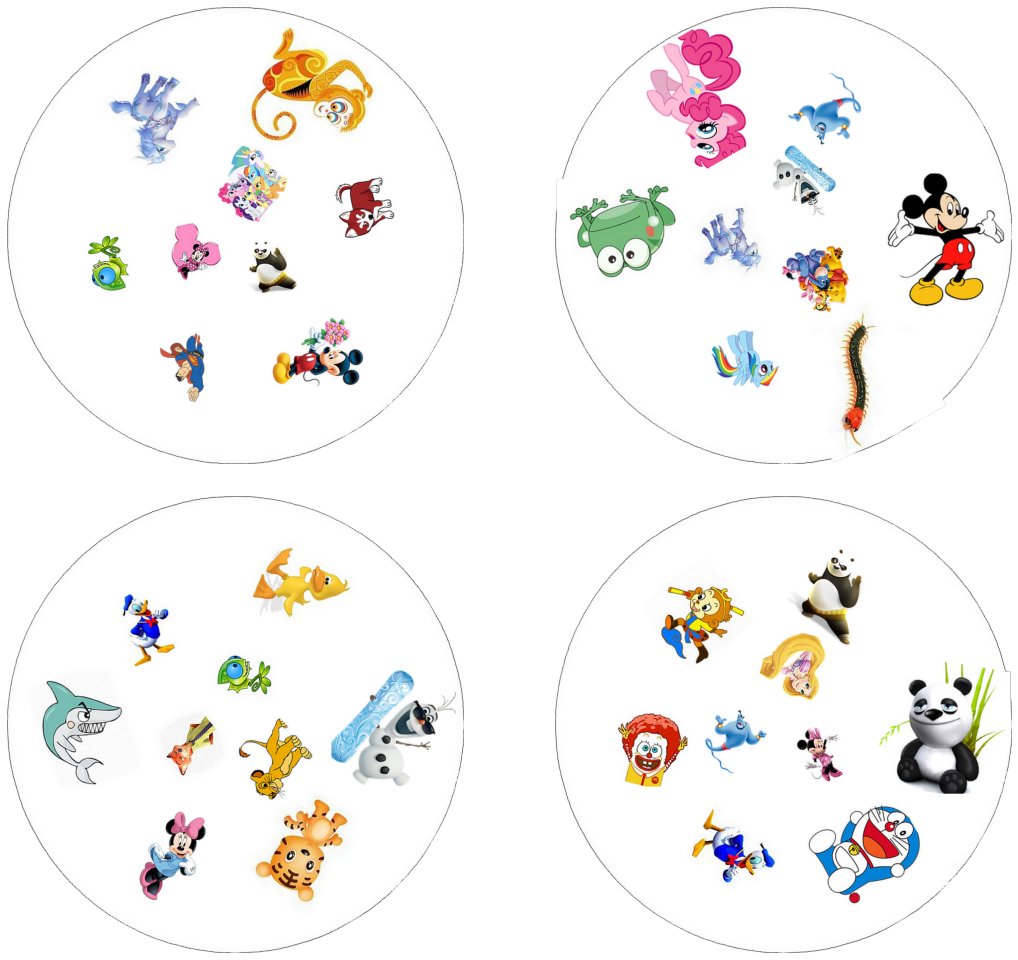

In [421]:
random.shuffle(outfiles)
nrow, ncol = 2, 2
fig = plt.figure(figsize=(9*nrow, 9*ncol))
for i in range(nrow*ncol):
    ax = fig.add_subplot(nrow, ncol, i+1)
    plt.axis('off')
    plt.imshow(Image.open(outfiles[i]))
plt.subplots_adjust(wspace =0.2, hspace =0)